In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# from skimage import data
from skimage import transform as tf
from skimage.transform import rotate

RESIZED_IMAGE_WIDTH = 20
RESIZED_IMAGE_HEIGHT = 30

classifications = np.loadtxt("classifications.txt") #, , fmt='%i')
flattened_images = np.loadtxt("flattened_images.txt")#,  fmt='%i')

In [2]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

We have a single sample for each digit, so we want to use warpping to produce more samples. To do that, we need the un-flattened images.

In [3]:
images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in flattened_images ]

In [4]:
def show_raw(images, labels):
    
    fig, ax = plt.subplots(ncols=len(images), sharex=False, sharey=False)
    for i in range(len(images)):
        ax[i].imshow(images[i], cmap=plt.cm.gray)
        ax[i].axis('off')
        if labels is not None:
            ax[i].set_title(labels[i])
    
    plt.show()

In [5]:
def show_all(images, labels=None):
    if labels is not None:
        image_sets = list(grouper(images, 6, np.zeros(images[0].shape, dtype=np.int)))
        label_sets = list(grouper(labels, 6, ''))
        for i, image_set in enumerate(image_sets):
            show_raw(image_set, labels=label_sets[i])
    else:
        [ show_raw(z, ['']*6) for z in grouper(images, 6, np.zeros(images[0].shape, dtype=np.int)) ]

In [6]:
[chr(int(z)) for z in classifications]

['9', '8', '7', '6', '5', '4', '3', '2', '1', '0']

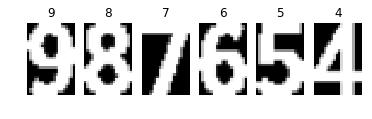

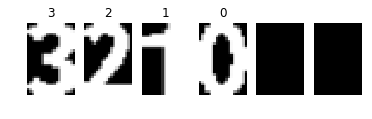

In [7]:
show_all(images, labels=[chr(int(z)) for z in classifications])

Prep sample

In [8]:
import cv2

In [66]:
MIN_CONTOUR_AREA = 50

RESIZED_IMAGE_WIDTH = 20
RESIZED_IMAGE_HEIGHT = 30
# font = cv2.FONT_HERSHEY_SIMPLEX
font = cv2.FONT_HERSHEY_COMPLEX_SMALL

def preprocess_score_image(original):
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    image = bw_image.copy()
    img_contours, npa_contours, npa_hierarchy = cv2.findContours(image,
                                                 cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_SIMPLE)
    
    digits = []

    for i, npa_contour in enumerate(npa_contours):
        if cv2.contourArea(npa_contour) > MIN_CONTOUR_AREA:
            [intX, intY, intW, intH] = cv2.boundingRect(npa_contour)
            cv2.rectangle(original, (intX, intY), (intX+intW,intY+intH), (0, 0, 255), 2)
            imgROI = image[intY:intY+intH, intX:intX+intW]
            resized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
            flattened = resized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))
            digits.append((intX, flattened,))

    flattened_digits =  np.empty((0, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT), dtype=np.int)
    for _, digit in sorted(digits, key=lambda z: z[0]):
        flattened_digits = np.append(flattened_digits, digit, 0)

    return flattened_digits

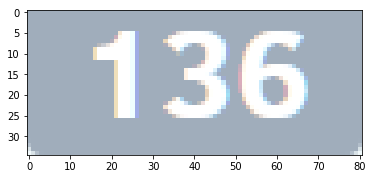

(600,)
(600,)
(600,)


In [67]:
test_source = cv2.imread("samples/test_score.png")
plt.imshow(test_source, cmap=plt.cm.gray)
plt.show()

test = preprocess_score_image(test_source)
for digit in test:
    print(digit.shape)

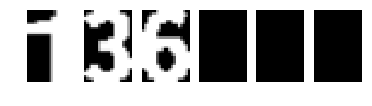

In [68]:
test_images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in test ]
show_all(test_images)

Test sample was taken at 30x30 instead of the 20x30 used by the training samples; will reshape the test sample

In [49]:
print(flattened_images.shape)
print(classifications.shape)

(10, 600)
(10,)


In [50]:
from sklearn import svm

In [51]:
clf = svm.NuSVC()
clf.fit(flattened_images, classifications)

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)

In [52]:
for digit in test:
    predict = clf.predict([digit])
    print(chr(int(predict)))

9
9
9


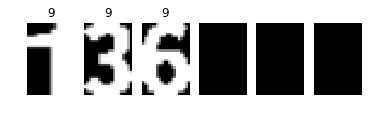

In [53]:
predictions = [ clf.predict([z]) for z in test ]
show_all(test_images, labels=[ chr(z) for z in predictions])

Grid search

In [54]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [55]:
more_params = {'clf__nu' : [0.8, 0.65, 0.5, 0.35, 0.2],
            'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', ],
            'clf__shrinking' : [True, False],
            'clf__tol' : [0.01, 0.003, 0.001, 0.0003, 0.0001],
            'clf__decision_function_shape' : ['ovo', 'ovr'],
        }

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [57]:
# need more samples to have the CV

double_samples = np.concatenate((flattened_images, flattened_images), axis=0)
double_classes = np.concatenate((classifications, classifications), axis=0)

In [58]:
def grid_search():
    params = {
        'clf__random_state' : [1337]
    }

    params.update(more_params)

    pipeline = Pipeline([
        ('clf', svm.NuSVC())
    ])

    grid_search = GridSearchCV(pipeline, param_grid=params, cv=2, n_jobs=4)

    grid_search.fit(double_samples, double_classes )
    report(grid_search.cv_results_)

In [59]:
grid_search()

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.8, 'clf__random_state': 1337, 'clf__shrinking': True, 'clf__tol': 0.01}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.8, 'clf__random_state': 1337, 'clf__shrinking': True, 'clf__tol': 0.003}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.8, 'clf__random_state': 1337, 'clf__shrinking': True, 'clf__tol': 0.001}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.8, 'clf__random_state': 1337, 'clf__shrinking': True, 'clf__tol': 0.0003}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'clf__decision_function_sh

In [60]:
clf = svm.NuSVC(decision_function_shape='ovo', kernel='linear', nu=0.8, random_state=1337, shrinking=True, tol=0.01)
clf.fit(flattened_images, classifications)

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, nu=0.8, probability=False, random_state=1337,
   shrinking=True, tol=0.01, verbose=False)

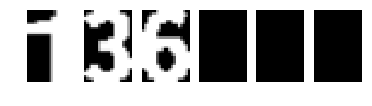

In [61]:
test_images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in test ]
show_all(test_images)

In [62]:
for digit in test:
    predict = clf.predict([digit])
    print(chr(int(predict)))

1
3
6


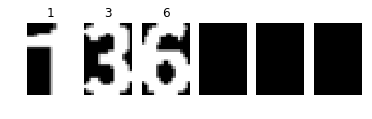

In [63]:
predictions = [ clf.predict([z]) for z in test ]
show_all(test_images, labels=[ chr(z) for z in predictions])

In [64]:
import pickle
with open('score_model.pickle', 'wb') as f:
    pickle.dump(clf, f)

with open('score_model.pickle', 'rb') as f:
    clf2 = pickle.load(f)
first_digit = clf2.predict([test[0]])
print('first digit of the score sample is', chr(first_digit))

first digit of the score sample is 1


In [29]:
fail here

SyntaxError: invalid syntax (<ipython-input-29-a2f04ec58aab>, line 1)

Before applying any other transformations, let's add padding to serve as buffer for the results that will be off center

In [ ]:
def padding(image, pixels=3):
    return np.lib.pad(image, (pixels,pixels), 'constant', constant_values=(0,0))

In [ ]:
padded_iamges = [ padding(z) for z in images]

In [ ]:
pd.set_option('max_rows', 55)
oneimage = pd.DataFrame(padded_iamges[0])
print(oneimage)

In [ ]:
pd.reset_option('max_rows')

In [ ]:
show_all(padded_iamges)

One of the warping procedures will be [rotating at the center](https://stackoverflow.com/questions/25895587/python-skimage-transform-affinetransform-rotation-center)

In [ ]:
def center_rotate(image, degrees):
    shift_y, shift_x = np.array(image.shape[:2]) / 2. 
    # I guess the shape[:2] is to cut off a 3rd color dimension
    tf_rotate = tf.SimilarityTransform(rotation=np.deg2rad(degrees))
    tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])

    image_rotated = tf.warp(image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
    # so it shifts the center of the image to the origin point, then rotates, and then
    # shifts back the center of the image to the center of the "canvas"
    # All the "transforms" are matrices - why exactly this arithmetic works ...
    return image_rotated
    
    

Apply different degree of transformation:

In [ ]:
pad_n_rot = []
for i in padded_iamges:
   pad_n_rot += [ center_rotate(i, z) for z in range(-10,15,5) ]

Display the transformations

In [ ]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

In [ ]:
show_all(pad_n_rot)

In [ ]:
def scale_up(image, pixels=3):
    resized = tf.resize(image,(image.shape[0]+pixels*2,image.shape[1]+pixels*2), mode='edge')
    return resized[pixels:-pixels, pixels:-pixels]

In [ ]:
scaled = [ scale_up(z) for z in padded_iamges ]

In [ ]:
show_all(padded_iamges + scaled)

In [ ]:
def scale_down(image, pixels=3):
    resized = tf.resize(image,(image.shape[0]+pixels*2,image.shape[1]+pixels*2), mode='edge')
    return padding(resized, pixels)

In [ ]:
scaled = [ scale_down(z) for z in padded_iamges ]
show_all(padded_iamges + scaled)

In [ ]:
oneimage.shape

In [ ]:
resized = tf.resize(oneimage,(46,36), mode='edge')
reform = resized[3:-3,3:-3]

In [ ]:
plt.figure(figsize=(20, 14));
ax = plt.subplot(1, 3, 1);
plt.imshow(oneimage);
plt.gray()
ax = plt.subplot(1, 3, 2);
plt.imshow(resized);
plt.gray()
ax = plt.subplot(1, 3, 3);
plt.imshow(reform);
plt.gray()

In [ ]:
[ print(z.shape) for z in [oneimage, resized]]

Another transformation will be translation